### Analysis and plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

%matplotlib inline

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

When do we have ASTER observations of this site? (convert from UTC to UTC-8)

In [10]:
# Find all our ASTER files for the CUES site
directory1 = r'//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_Tuolumne-and-CUES/T_Tuolumne_only/'
directory2 = r'//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_Tuolumne-and-CUES/T_both/'

aster_files = getListOfFiles(directory1) + getListOfFiles(directory2)

## Parse the date and time from ASTER filenames
aster_datetimes = []
for fpath in aster_files:
    #fn = re.split('\/+|\\+',fpath)[-1] # re method
    fn = fpath.split('/')[-1] # non-re method
    MM = fn.split('_')[2][3:5]
    DD = fn.split('_')[2][5:7]
    YYYY = fn.split('_')[2][7:11]
    hh = fn.split('_')[2][11:13]
    mm = fn.split('_')[2][13:15]
    ss = fn.split('_')[2][15:17]
    aster_datetimes.append(pd.Timestamp('{}-{}-{} {}:{}:{}'.format(YYYY, MM, DD, hh, mm, ss)) - pd.Timedelta(hours=8))

aster = pd.DataFrame({'datetime': aster_datetimes, 'filepath': aster_files})
aster.sort_values('datetime',inplace=True)
aster.reset_index(inplace=True, drop=True)

Set font sizes for plots

In [11]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [10]:
from datetime import timedelta, datetime

def datetimerange(start_date, end_date, n_hours):
    # https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python/1060330#1060330
    # for every hour in this date range
    for n in range(int ( (end_date - start_date).total_seconds() / 3600 )):
        # if we've moved n_hours
        if n % n_hours == 0:
            # return the start date + that many hours we've stepped forward
            yield start_date + timedelta(hours=n)

---

# Open datasets

In [6]:
df_snow_6 = pd.read_pickle('data/goes-cues-2017-2020-6hr_snow.pkl')

In [7]:
df_snow_1 = pd.read_pickle('data/goes-cues-2017-2020-1hr_snow.pkl')

In [60]:
df_snow_6.head()

,rsquared,covar,mae,mbe,rmse,slope,year_month
datetime,,,,,,,
2017-03-01 00:00:00,0.495753,0.251211,8.046598,8.046598,8.118179,0.157395,2017-03
2017-03-01 06:00:00,0.925115,31.961398,9.489138,9.489138,9.674713,0.803744,2017-03
2017-03-01 12:00:00,0.840236,3.715182,3.294253,3.294253,3.474634,1.327503,2017-03
2017-03-01 18:00:00,0.446110,0.856716,7.252447,7.252447,7.428530,0.218850,2017-03
2017-03-02 00:00:00,0.302394,0.362301,9.124983,9.124983,9.452707,0.053014,2017-03


### for inspecting the entire time series (6-hr)

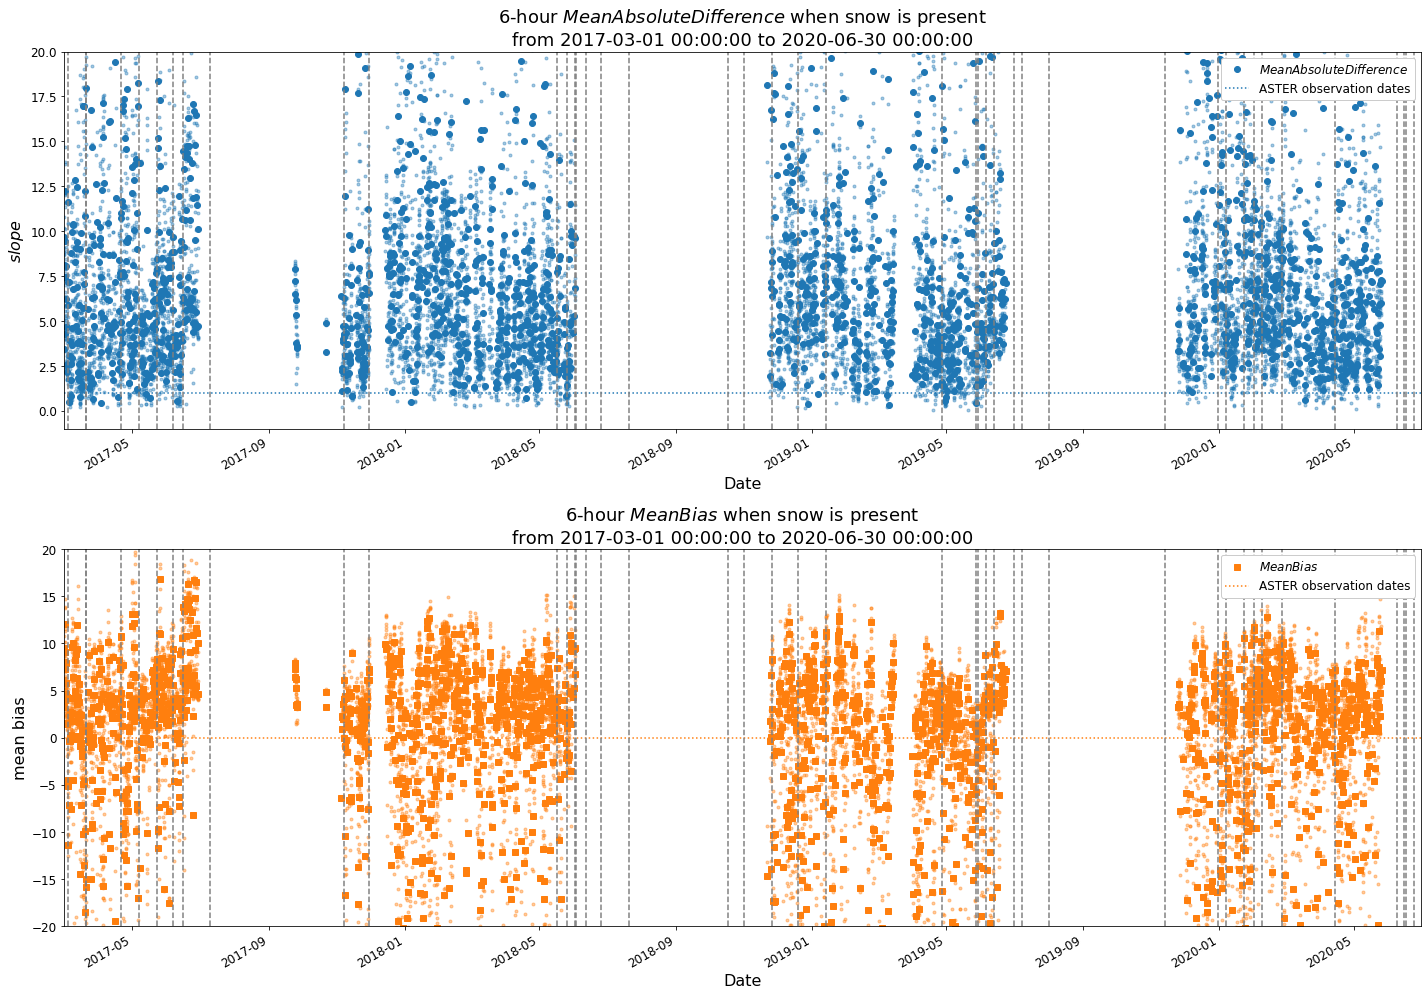

In [64]:
# Set start and end dates for time period we want to look at
startdate = pd.Timestamp('2017-03-01')
enddate = pd.Timestamp('2020-06-30')

# Set up figure
fig, ax = plt.subplots(2,1,figsize=(20,14))

df_snow_6.rmse.plot(linestyle='none',marker='o',c='tab:blue',ax=ax[0], label='slope')
df_snow_1.rmse.plot(linestyle='none',marker='.',c='tab:blue',ax=ax[0], alpha=0.4)
ax[0].axhline(y=1,linestyle=':',color='tab:blue')
ax[0].set_ylim([-1,20])
ax[0].set_ylabel('$slope$')

#ax2 = ax.twinx()
#df.rmse.plot(linestyle='-',marker='.',c='tab:orange',ax=ax2)
#df.mae.plot(linestyle='-',marker='.',c='tab:red',ax=ax2)
df_snow_6.mbe.plot(linestyle='none',marker='s',c='tab:orange',ax=ax[1], label='mean bias')
df_snow_1.mbe.plot(linestyle='none',marker='.',c='tab:orange',ax=ax[1], alpha=0.4)
ax[1].axhline(y=0,linestyle=':',color='tab:orange')
ax[1].set_ylim([-20,20])
ax[1].set_ylabel('mean bias')


ax[0].set_xlim([startdate,enddate])
ax[0].set_xlabel('Date')
ax[1].set_xlim([startdate,enddate])
ax[1].set_xlabel('Date')

# Plot when we have ASTER observations of the CUES site
for aster_datetime in aster.datetime:
    ax[0].axvline(x=aster_datetime, color='grey', linestyle='--')
    ax[1].axvline(x=aster_datetime, color='grey', linestyle='--')

# Set titles
ax[0].set_title('6-hour $Mean Absolute Difference$ when snow is present\nfrom {} to {}'.format(startdate,enddate));
ax[1].set_title('6-hour $Mean Bias$ when snow is present\nfrom {} to {}'.format(startdate,enddate));
# make legends
lines = [ax[0].lines[0], ax[0].lines[2]]
labels = ['$Mean Absolute Difference$', 'ASTER observation dates']
ax[0].legend(lines, labels, loc='upper right', facecolor='white', framealpha=1)
lines = [ax[1].lines[0], ax[1].lines[2]]
labels = ['$Mean Bias$', 'ASTER observation dates']
ax[1].legend(lines, labels, loc='upper right', facecolor='white', framealpha=1)

# Save figure image
plt.tight_layout()
#plt.savefig('goes-vs-cues-2017-2020.jpg',dip=300);

Boxplot customization

In [20]:
boxprops = dict(linestyle='-', linewidth=1)
flierprops = dict(marker='.', markerfacecolor='#bbbbbb', markeredgecolor='none', markersize=3,linestyle='none')
medianprops = dict(linestyle='-', linewidth=1)
meanpointprops = dict(marker='o', markeredgecolor='none',markerfacecolor='k')
meanlineprops = dict(linestyle=':', linewidth=1, color='k')
whiskerprops = dict(color='k', linewidth=1, linestyle='-')
capprops = dict(color='k')


### Look at difference between 6-hourly and 1-hourly stats

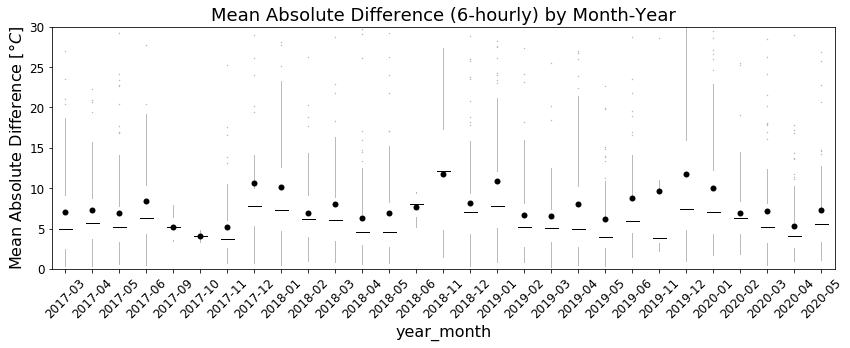

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5), sharex=True)



# Boxplots for snow vs GOES
boxplot = df_snow_6.boxplot(column='mae', by='year_month',
                          ax=ax,
                          backend='matplotlib',
                          grid=False,
                          meanline=False,
                          showbox=False,
                          showcaps=False,
                          showmeans=True,
                          color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                          boxprops=boxprops,
                          whiskerprops=whiskerprops,
                          capprops=capprops,
                          flierprops=flierprops,
                          medianprops=medianprops,
                          meanprops=meanpointprops)



ax.set_title('Mean Absolute Difference (6-hourly) by Month-Year')
plt.suptitle('') # this removes pandas' default title
# Boxplot x-axis formatting
plt.xticks(rotation=45, horizontalalignment='center');
plt.ylim(0,30);
ax.set_ylabel('Mean Absolute Difference [$\degree C$]')



plt.tight_layout()
#plt.savefig('figures/mean-absolute-difference-monthly.jpg')

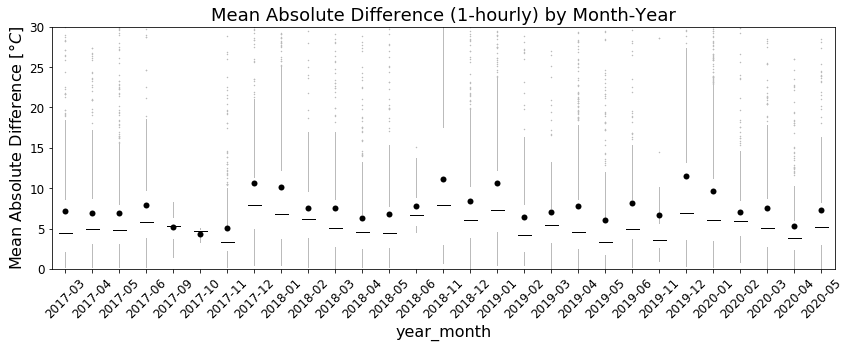

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5), sharex=True)



# Boxplots for snow vs GOES
boxplot = df_snow_1.boxplot(column='mae', by='year_month',
                          ax=ax,
                          backend='matplotlib',
                          grid=False,
                          meanline=False,
                          showbox=False,
                          showcaps=False,
                          showmeans=True,
                          color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                          boxprops=boxprops,
                          whiskerprops=whiskerprops,
                          capprops=capprops,
                          flierprops=flierprops,
                          medianprops=medianprops,
                          meanprops=meanpointprops)



ax.set_title('Mean Absolute Difference (1-hourly) by Month-Year')
plt.suptitle('') # this removes pandas' default title
# Boxplot x-axis formatting
plt.xticks(rotation=45, horizontalalignment='center');
plt.ylim(0,30);
ax.set_ylabel('Mean Absolute Difference [$\degree C$]')



plt.tight_layout()
#plt.savefig('figures/mean-absolute-difference-monthly.jpg')

### Mean Absolute Difference

by Month-Year for 6-hourly stats

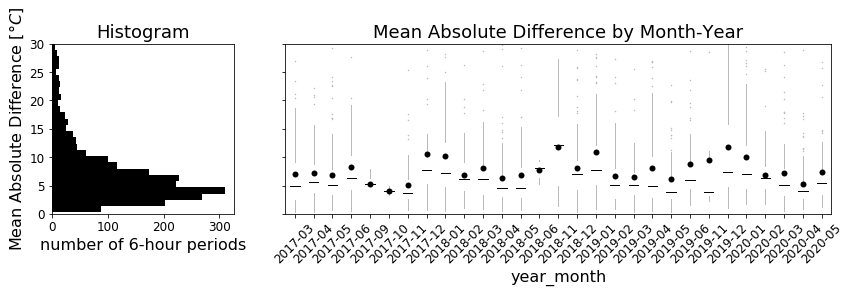

In [37]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True, gridspec_kw={'width_ratios': [1, 3]})

# Boxplots
boxplot = df_snow_6.boxplot(column='mae', by='year_month',
                            ax=ax[1],
                            backend='matplotlib',
                            grid=False,
                            meanline=False,
                            showbox=False,
                            showcaps=False,
                            showmeans=True,
                            color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                            boxprops=boxprops,
                            whiskerprops=whiskerprops,
                            capprops=capprops,
                            flierprops=flierprops,
                            medianprops=medianprops,
                            meanprops=meanpointprops)
ax[1].set_title('Mean Absolute Difference by Month-Year')
plt.suptitle('') # this removes pandas' default title
# Boxplot x-axis formatting
plt.xticks(rotation=45, horizontalalignment='center');

# Histogram
ax[0].hist(df_snow_6.mae,
           bins=int(np.sqrt(len(df_snow_6.mae))),
           orientation='horizontal',
           color = '#000000',
           ec='none',
           lw=1)
ax[0].set_title('Histogram')
# Histogram x-axis formatting
ax[0].set_xlabel('number of 6-hour periods')

# Format shared y-axis
plt.ylim(0,30);
ax[0].set_ylabel('Mean Absolute Difference [$\degree C$]')

plt.tight_layout()
plt.savefig('figures/mean-absolute-difference-monthly.jpg')

### Mean Bias

by Month-Year for 6-hourly stats

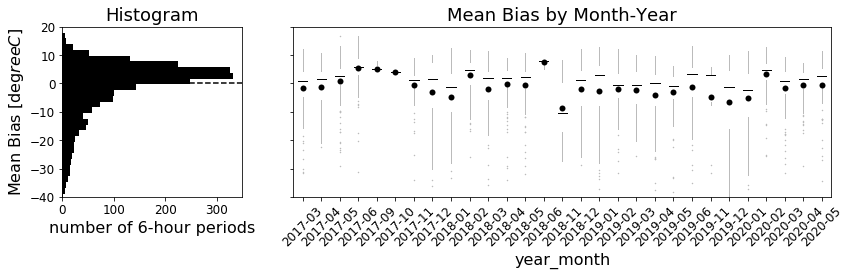

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True, gridspec_kw={'width_ratios': [1, 3]})

# Boxplots
boxplot = df_snow_6.boxplot(column='mbe', by='year_month',
                            ax=ax[1],
                            backend='matplotlib',
                            grid=False,
                            meanline=False,
                            showbox=False,
                            showcaps=False,
                            showmeans=True,
                            color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                            boxprops=boxprops,
                            whiskerprops=whiskerprops,
                            capprops=capprops,
                            flierprops=flierprops,
                            medianprops=medianprops,
                            meanprops=meanpointprops)
ax[1].set_title('Mean Bias by Month-Year')
plt.suptitle('') # this removes pandas' default title
# Boxplot x-axis formatting
plt.xticks(rotation=45, horizontalalignment='center');

# Histogram
ax[0].hist(df_snow_6.mbe,
           bins=int(np.sqrt(len(df_snow_6.mbe))),
           orientation='horizontal',
           color = '#000000',
           ec='none',
           lw=1)
ax[0].axhline(y=0,linestyle='--',color='k')
ax[0].set_title('Histogram')
# Histogram x-axis formatting
ax[0].set_xlabel('number of 6-hour periods')

# Format shared y-axis
plt.ylim(-40,20);
ax[0].set_ylabel('Mean Bias [$\degreeC$]')

plt.tight_layout()
plt.savefig('figures/mean-biases-monthly.jpg')

**Mean Bias**

by month for each year, 6-hourly

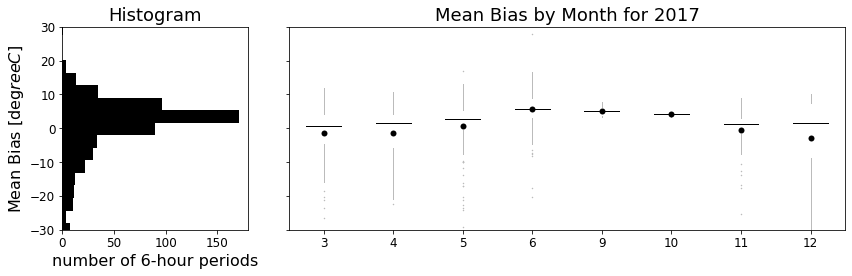

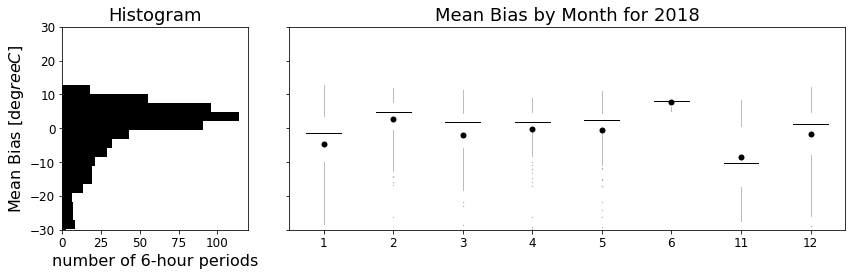

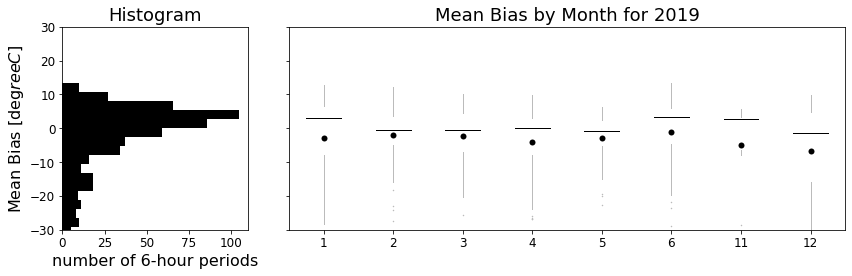

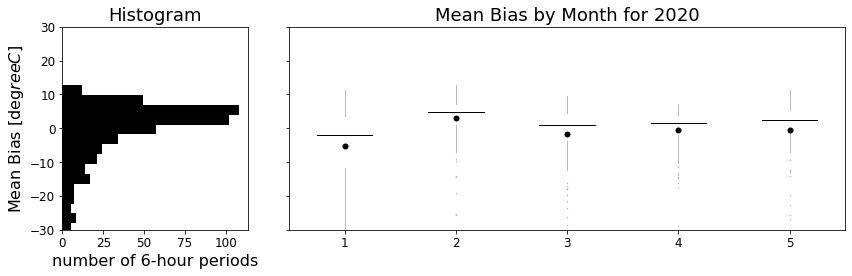

In [40]:
df = df_snow_6.copy()
for year in df.index.year.unique():
    
    mask = df.index.year==year
    df_n = df.loc[mask]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True, gridspec_kw={'width_ratios': [1, 3]})
    
    # Boxplots
    boxplot = df_n.boxplot(column='mbe', by=df_n.index.month,
                         ax=ax[1],
                         backend='matplotlib',
                         grid=False,
                         meanline=False,
                         showbox=False,
                         showcaps=False,
                         showmeans=True,
                         color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                         boxprops=boxprops,
                         whiskerprops=whiskerprops,
                         capprops=capprops,
                         flierprops=flierprops,
                         medianprops=medianprops,
                         meanprops=meanpointprops)
    ax[1].set_title('Mean Bias by Month for {}'.format(year))
    plt.suptitle('') # this removes pandas' default title
    ax[1].set_xlabel('') # this removes pandas' default x labels
    # Boxplot x-axis formatting
    #plt.xticks(rotation=45, horizontalalignment='center');
    
    # Histogram
    ax[0].hist(df_n.mbe,
               bins=int(np.sqrt(len(df_n.mbe))),
               orientation='horizontal',
               color = '#000000',
               ec='none',
               lw=1)
    ax[0].set_title('Histogram')
    # Histogram x-axis formatting
    ax[0].set_xlabel('number of 6-hour periods')
    
    # Format shared y-axis
    plt.ylim(-30,30);
    ax[0].set_ylabel('Mean Bias [$\degreeC$]')
    
    plt.tight_layout()
    plt.savefig('figures/mean-bias-monthly-{}.jpg'.format(year))

### Mean Bias

Look at hour of day for each month (using the 1-hourly stats)

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot inte

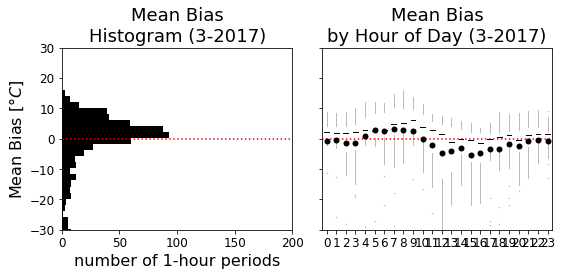

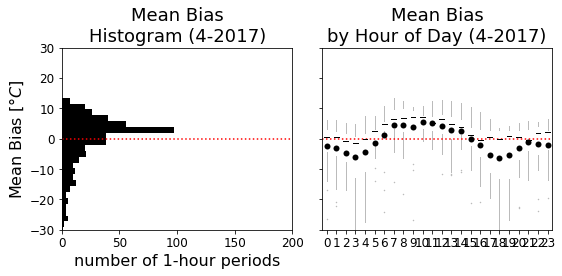

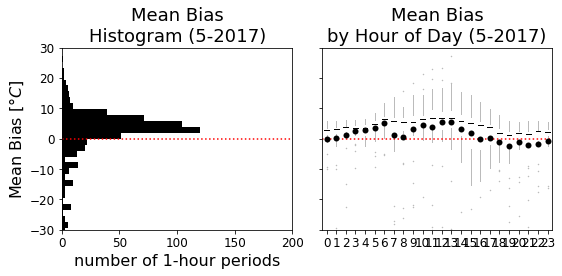

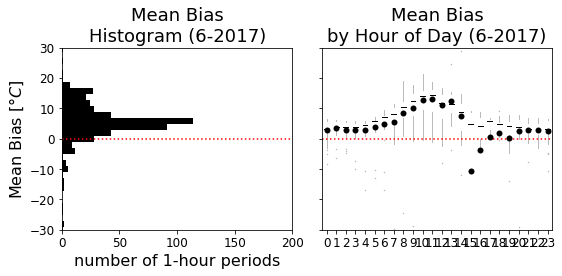

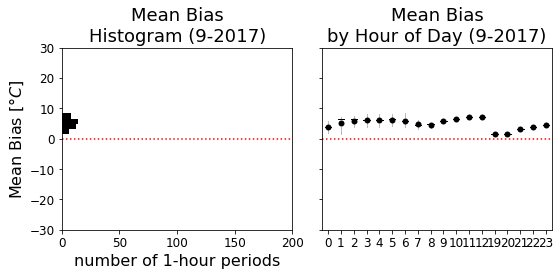

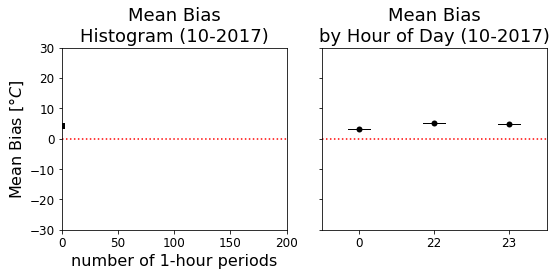

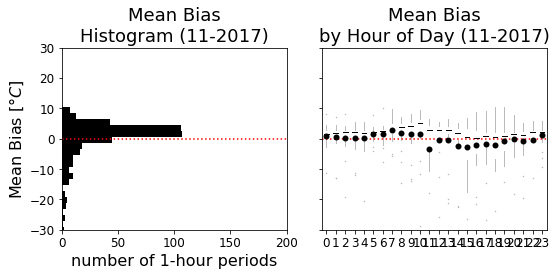

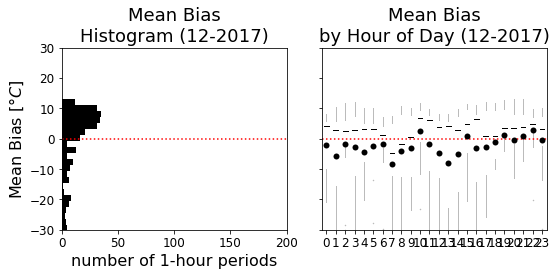

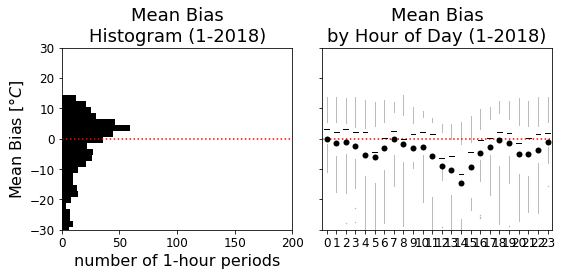

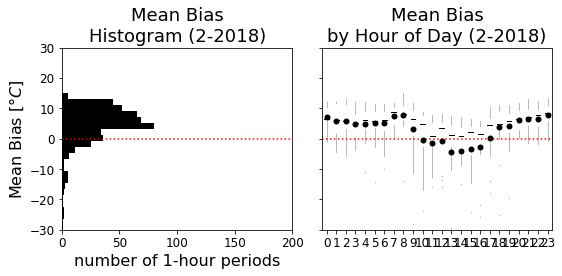

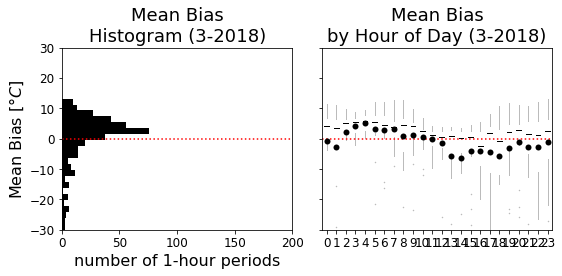

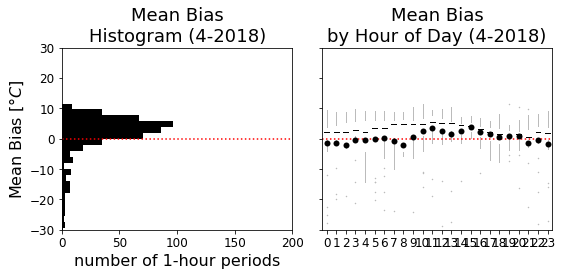

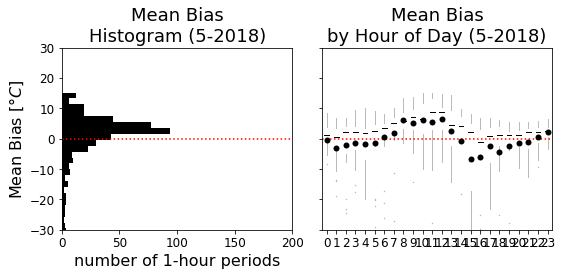

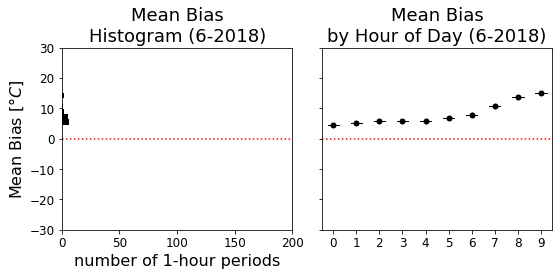

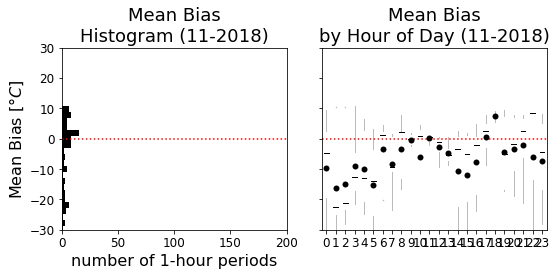

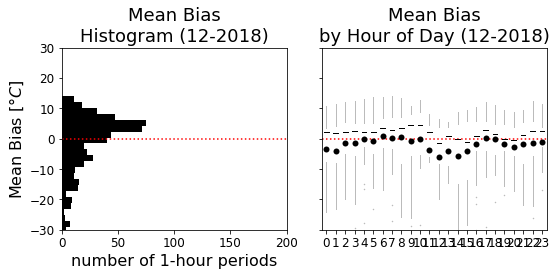

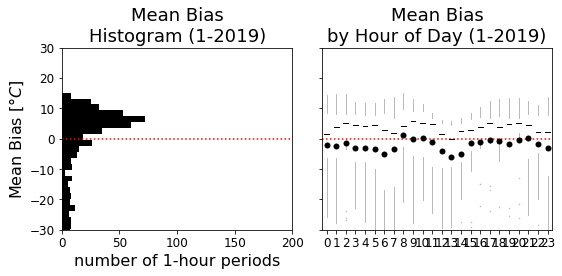

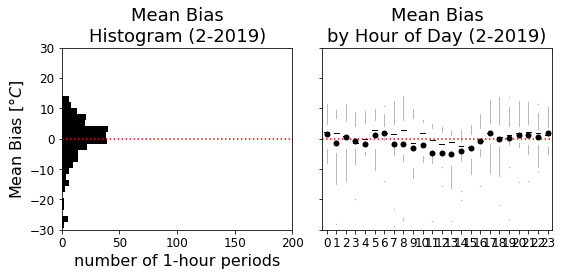

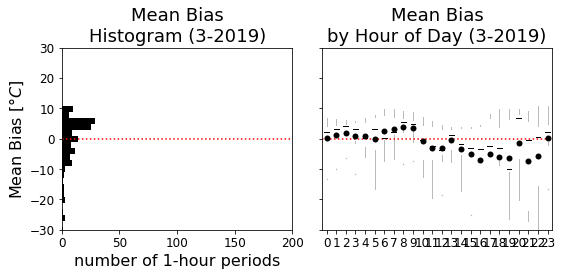

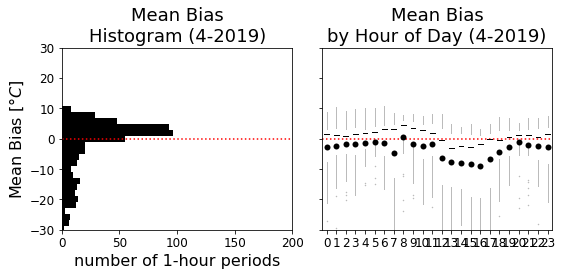

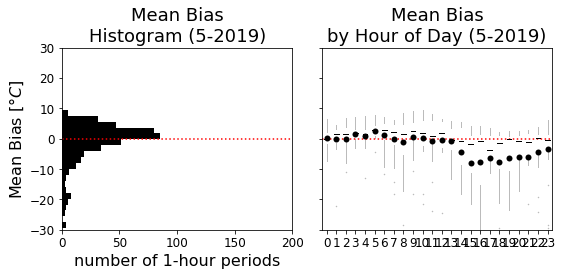

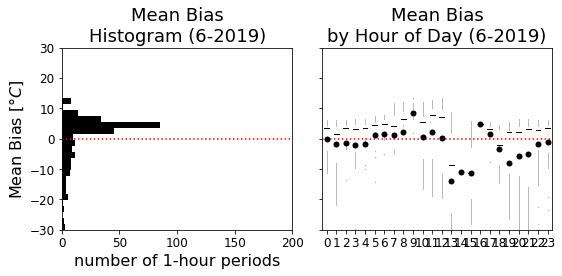

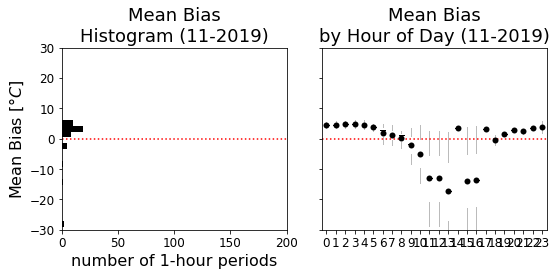

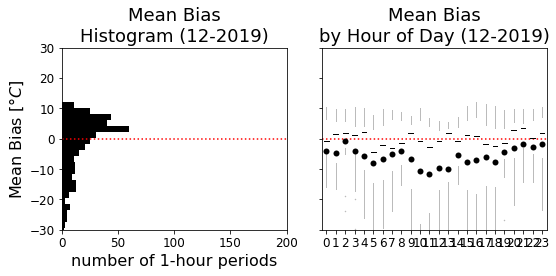

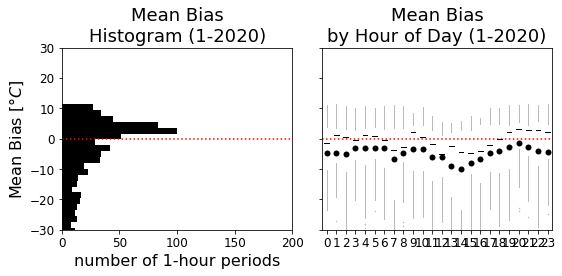

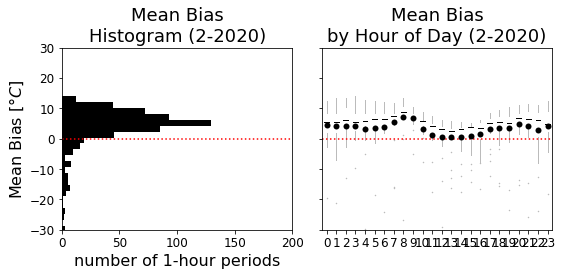

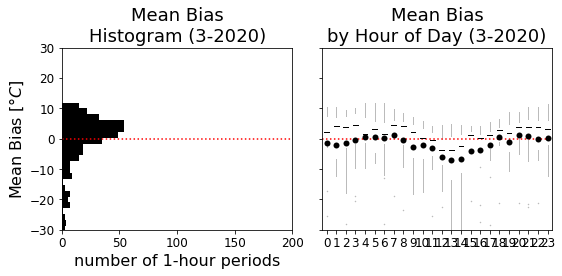

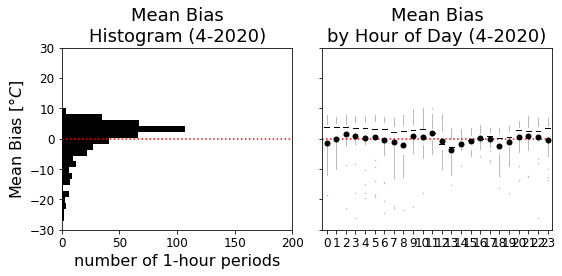

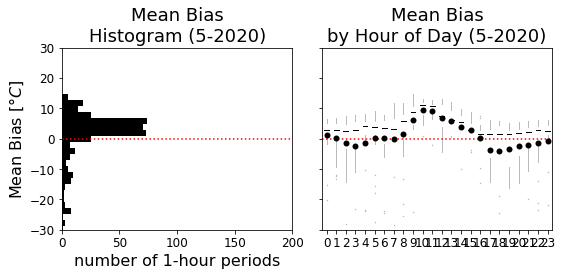

In [39]:
df = df_snow_1.copy()

for year in df.index.year.unique():
    mask = df.index.year==year
    df_n = df.loc[mask]
    
    for month in df_n.index.month.unique():
        mask = df_n.index.month==month
        df_m = df_n.loc[mask]

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True, gridspec_kw={'width_ratios': [1, 1]})

        # MAE Boxplots
        boxplot = df_m.boxplot(column='mbe', by=df_m.index.hour,
                             ax=ax[1],
                             backend='matplotlib',
                             grid=False,
                             meanline=False,
                             showbox=False,
                             showcaps=False,
                             showmeans=True,
                             color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                             boxprops=boxprops,
                             whiskerprops=whiskerprops,
                             capprops=capprops,
                             flierprops=flierprops,
                             medianprops=medianprops,
                             meanprops=meanpointprops)
        ax[1].set_title('Mean Bias\nby Hour of Day ({}-{})'.format(month,year))
        plt.suptitle('') # this removes pandas' default title
        ax[1].set_xlabel('') # this removes pandas' default x labels
        # Boxplot x-axis formatting
        #plt.xticks(rotation=45, horizontalalignment='center');
        ax[1].axhline(0,linestyle=':',color='r')


        # MAE Histogram
        ax[0].hist(df_m.mbe,
                   bins=int((df_m.mbe.max() - df_m.mbe.min())/2)+1,
                   orientation='horizontal',
                   color = '#000000',
                   ec='none',
                   lw=1)
        ax[0].axhline(0,linestyle=':',color='r')
        ax[0].set_title('Mean Bias\nHistogram ({}-{})'.format(month,year))
        # Histogram x-axis formatting
        ax[0].set_xlabel('number of 1-hour periods')
        ax[0].set_xlim(0,200)

        # Format shared y-axis
        plt.ylim(-30,30);
        ax[0].set_ylabel('Mean Bias [$\degree C$]')

        plt.tight_layout()
        plt.savefig('figures/mean-bias-hourly-{}-{}.jpg'.format(month,year))

Same as above, but group years together too:

Look at hour of day for each month (using the 1-hourly stats)

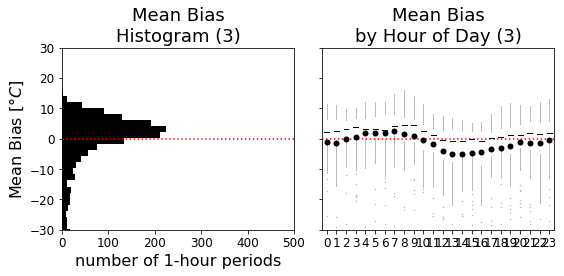

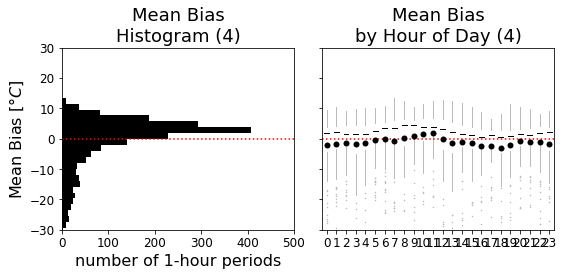

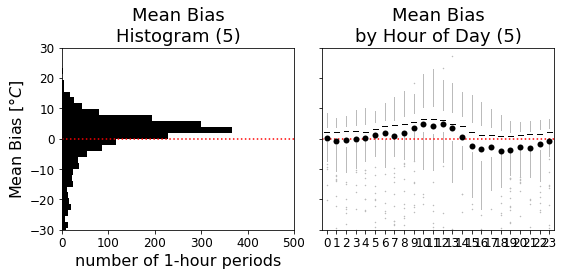

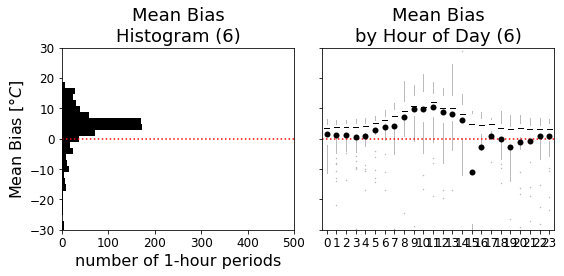

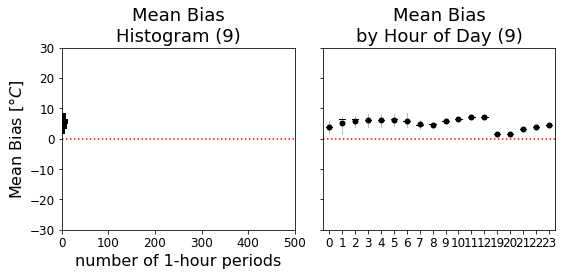

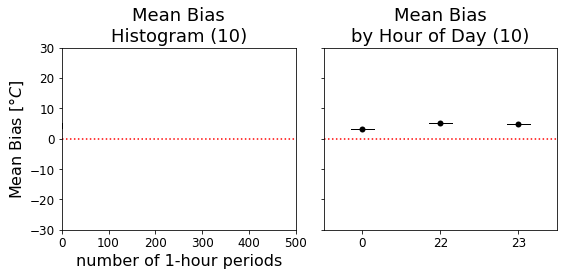

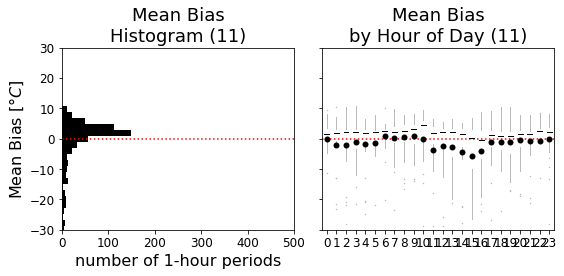

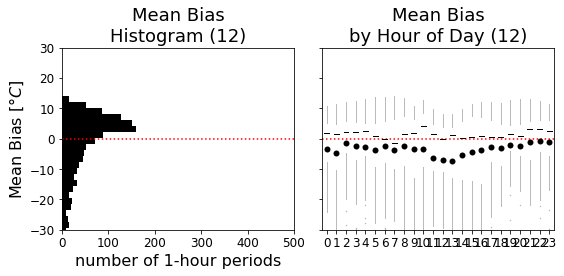

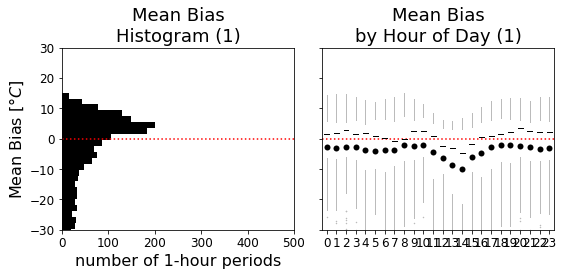

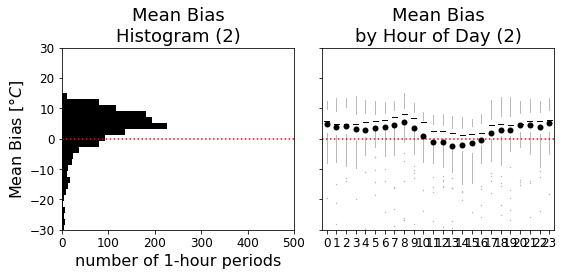

In [44]:
df = df_snow_1.copy()


for month in df.index.month.unique():
    mask = df.index.month==month
    df_m = df.loc[mask]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True, gridspec_kw={'width_ratios': [1, 1]})

    # MAE Boxplots
    boxplot = df_m.boxplot(column='mbe', by=df_m.index.hour,
                         ax=ax[1],
                         backend='matplotlib',
                         grid=False,
                         meanline=False,
                         showbox=False,
                         showcaps=False,
                         showmeans=True,
                         color=dict(boxes='#bbbbbb', whiskers='#bbbbbb', medians='k', caps='none'),
                         boxprops=boxprops,
                         whiskerprops=whiskerprops,
                         capprops=capprops,
                         flierprops=flierprops,
                         medianprops=medianprops,
                         meanprops=meanpointprops)
    ax[1].set_title('Mean Bias\nby Hour of Day ({})'.format(month))
    plt.suptitle('') # this removes pandas' default title
    ax[1].set_xlabel('') # this removes pandas' default x labels
    # Boxplot x-axis formatting
    #plt.xticks(rotation=45, horizontalalignment='center');
    ax[1].axhline(0,linestyle=':',color='r')


    # MAE Histogram
    ax[0].hist(df_m.mbe,
               bins=int((df_m.mbe.max() - df_m.mbe.min())/2)+1,
               orientation='horizontal',
               color = '#000000',
               ec='none',
               lw=1)
    ax[0].axhline(0,linestyle=':',color='r')
    ax[0].set_title('Mean Bias\nHistogram ({})'.format(month))
    # Histogram x-axis formatting
    ax[0].set_xlabel('number of 1-hour periods')
    ax[0].set_xlim(0,500)

    # Format shared y-axis
    plt.ylim(-30,30);
    ax[0].set_ylabel('Mean Bias [$\degree C$]')

    plt.tight_layout()
    plt.savefig('figures/mean-bias-hourly-{}.jpg'.format(month))